<a href="https://colab.research.google.com/github/dhruvipatel14/Anomaly-detection-using-fbprophet/blob/main/Anomaly_detection_using_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Detailed analysis and Anomaly detection on taxi demands in New york city using FBProphet algorithm.




In [1]:
!pip install fbprophet

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as datetime
import pandas as pd
import plotly.express as px
from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


Resampling data by per hour

In [6]:
df=df.set_index('timestamp').resample("H").mean()
df.head

<bound method NDFrame.head of                        value
timestamp                   
2014-07-01 00:00:00   9485.5
2014-07-01 01:00:00   5433.0
2014-07-01 02:00:00   3346.5
2014-07-01 03:00:00   2216.5
2014-07-01 04:00:00   2189.5
...                      ...
2015-01-31 19:00:00  28288.5
2015-01-31 20:00:00  24138.0
2015-01-31 21:00:00  24194.5
2015-01-31 22:00:00  26515.0
2015-01-31 23:00:00  26439.5

[5160 rows x 1 columns]>

Getting insights of demand of taxi.</br>
As we can see there is high demand on 6 sept, 2nd nov, 1st jan.</br>

We need to check these are anomaly or not.


In [7]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

changing the column name in the convention accepted by Fbprophet.

In [8]:
taxi_df=df.reset_index()[['timestamp','value']].rename({'timestamp':'ds','value':'y'}, axis='columns')
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


Spliting dataset into train and test

In [9]:
train=taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test=taxi_df[(taxi_df['ds'] > '2015-01-27')]

In [10]:
print(train.shape)
print(test.shape)

(5041, 2)
(119, 2)


Fitting the Fbprophet model

In [11]:
model = Prophet(changepoint_range=0.95)
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [12]:
future = model.make_future_dataframe(periods=119,freq='H')
future.tail(120)

,ds
5040,2015-01-27 00:00:00
5041,2015-01-27 01:00:00
5042,2015-01-27 02:00:00
5043,2015-01-27 03:00:00
5044,2015-01-27 04:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


Predicting and plotting the future data same as the size of test data

In [13]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19191.394071,28321.997101
5156,2015-01-31 20:00:00,24342.584334,19348.476219,29214.537471
5157,2015-01-31 21:00:00,23219.297735,18634.188703,28334.019256
5158,2015-01-31 22:00:00,21027.355314,16125.804620,25511.389352
5159,2015-01-31 23:00:00,18500.216845,13662.066008,23087.415915


In [14]:
results = pd.concat([taxi_df.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis = 1)

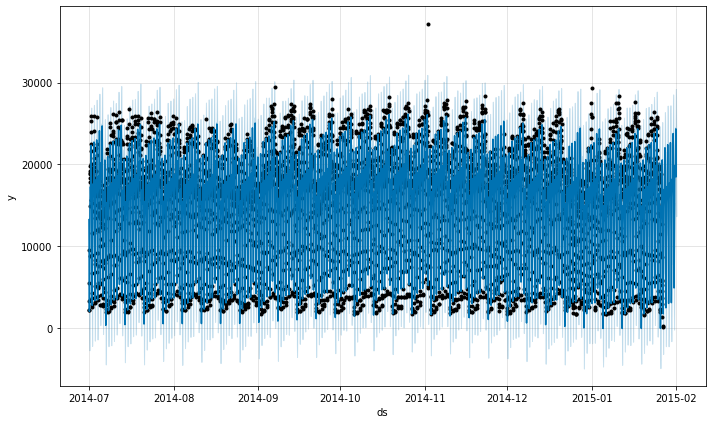

In [15]:
fig1 = model.plot(forecast)

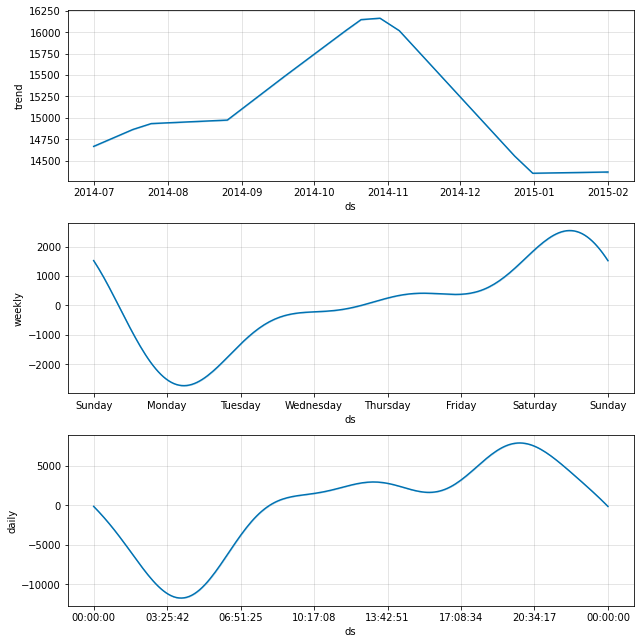

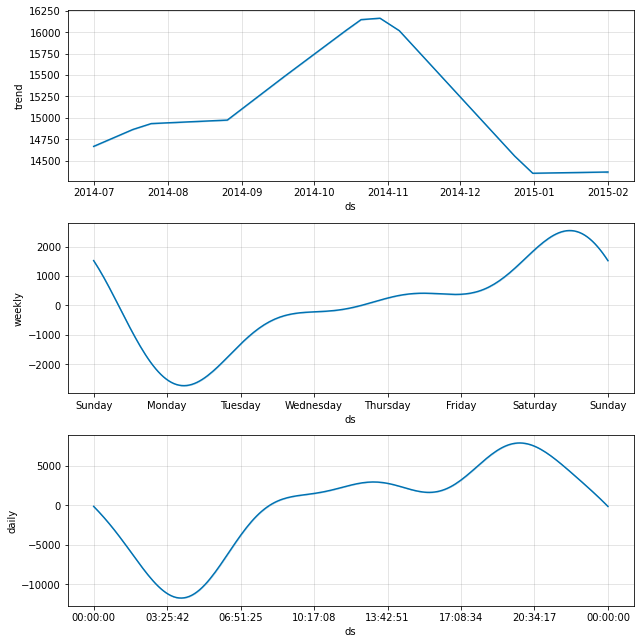

In [16]:
model.plot_components(forecast)

Calculating the error and uncertainty in the predictions.

In [17]:
results['error'] = results['y'] - results['yhat']

In [18]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [19]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8578.788189,17885.098521,-3755.232792,9306.310331
2014-07-01 01:00:00,5433.0,10232.486172,5788.793242,15101.622797,-4799.486172,9312.829555
2014-07-01 02:00:00,3346.5,6669.099458,1690.381162,11449.938157,-3322.599458,9759.556995
2014-07-01 03:00:00,2216.5,3448.054270,-1295.129584,8222.266719,-1231.554270,9517.396304
2014-07-01 04:00:00,2189.5,2017.409931,-2734.594231,6580.974737,172.090069,9315.568968


In [20]:
results[results['error'].abs() >  1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9584.264123,18979.201257,22985.607130,9394.937135
2015-01-01 01:00:00,29292.0,11405.545567,6714.161978,16236.488932,17886.454433,9522.326954
2015-01-01 02:00:00,25753.5,7770.054639,3215.406406,12954.863942,17983.445361,9739.457535
2015-01-01 03:00:00,22067.0,4478.895177,-528.200415,9068.469764,17588.104823,9596.670179
2015-01-26 19:00:00,4565.5,19771.308307,15138.865690,24539.105637,-15205.808307,9400.239947
2015-01-26 20:00:00,3630.5,20546.581743,15416.366330,25167.021699,-16916.081743,9750.655369
2015-01-26 21:00:00,2907.0,19647.710004,15084.179616,24226.035008,-16740.710004,9141.855392
2015-01-26 22:00:00,1324.5,17691.969234,12815.903540,22582.238988,-16367.469234,9766.335448
2015-01-26 23:00:00,243.0,15411.348672,10684.378021,20453.381556,-15168.348672,9769.003536


Calculating the anomalous data by calculating the diffrence of error and uncertainy in data.</br>

Plotting the anomalous data points in red to get better differentiation.


In [21]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.5*x['uncertainty']) else 'No', axis=1)

In [22]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()